In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import datetime
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


In [3]:
df = pd.read_csv("data.csv", encoding='ISO-8859-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
df = df.dropna(subset=["CustomerID","InvoiceDate","Quantity","UnitPrice"])
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["CustomerID"] = df["CustomerID"].astype(str)
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

In [6]:
snapshot_date = df["InvoiceDate"].max() + datetime.timedelta(days=1)
rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
    "InvoiceNo": "nunique",
    "TotalPrice": "sum"
})
rfm.columns = ["Recency", "Frequency", "Monetary"]
rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


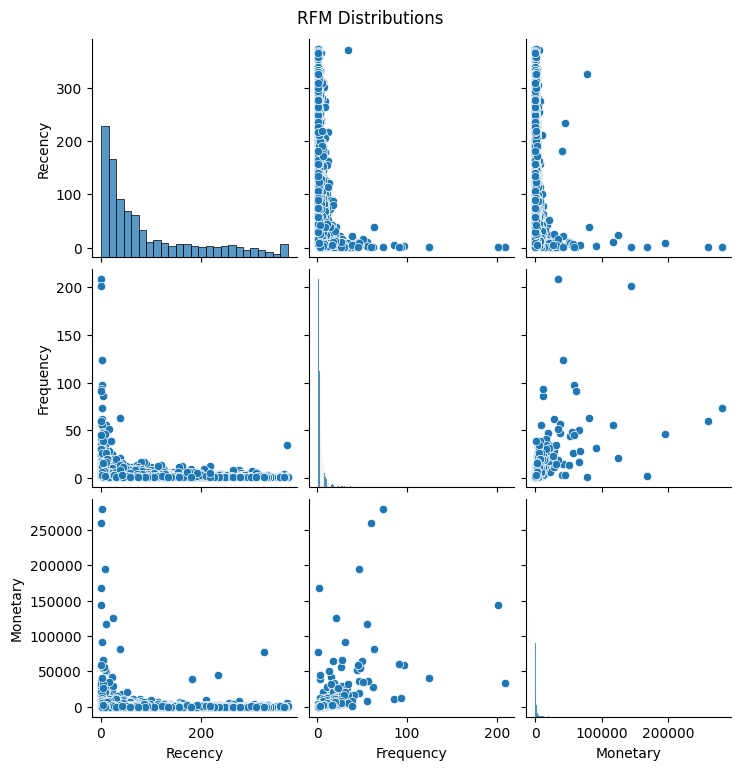

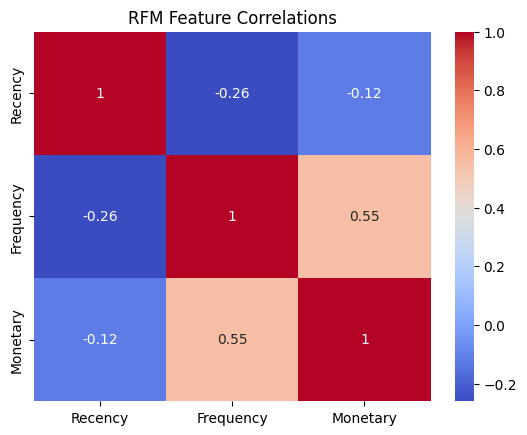

In [7]:
sns.pairplot(rfm)
plt.suptitle("RFM Distributions", y=1.02)
plt.show()

sns.heatmap(rfm.corr(), annot=True, cmap="coolwarm")
plt.title("RFM Feature Correlations")
plt.show()

In [8]:
X = rfm[["Recency", "Frequency"]]  # Features
y = rfm["Monetary"]               # Target (LTV)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [10]:
model = XGBRegressor()
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [11]:
y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))


MAE: 1793.1012666543006
RMSE: 10157.88416544955
R²: -0.007221381972055907


In [12]:
rfm["PredictedLTV"] = model.predict(rfm[["Recency", "Frequency"]])
rfm["Segment"] = pd.qcut(rfm["PredictedLTV"], q=3, labels=["Low", "Medium", "High"])
rfm.to_csv("customer_ltv_predictions.csv", index=False)


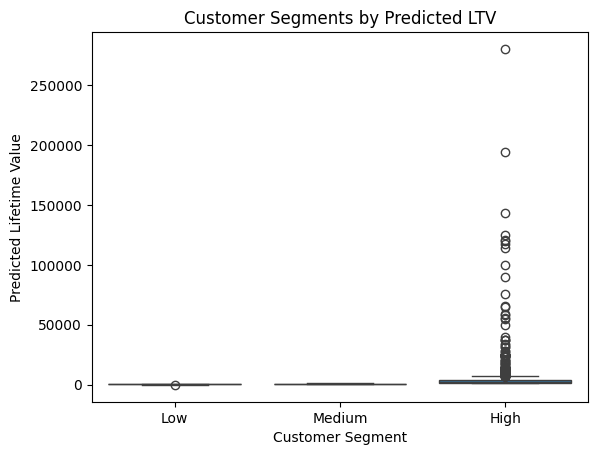

In [13]:
sns.boxplot(x="Segment", y="PredictedLTV", data=rfm)
plt.title("Customer Segments by Predicted LTV")
plt.xlabel("Customer Segment")
plt.ylabel("Predicted Lifetime Value")
plt.show()


In [14]:
rfm["PredictedLTV"] = model.predict(X)
rfm["PredictedLTV"] = rfm["PredictedLTV"].round(2)
rfm_sorted = rfm.sort_values("PredictedLTV", ascending=False)
rfm_sorted.head()



,Recency,Frequency,Monetary,PredictedLTV,Segment
CustomerID,,,,,
14646.0,2,73,280206.02,279906.062500,High
17450.0,8,46,194550.79,194370.187500,High
14911.0,1,201,143825.06,143579.078125,High
12415.0,24,21,124914.53,124428.726562,High
16422.0,17,51,34684.40,120454.757812,High


In [15]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[["Recency", "Frequency", "Monetary"]])


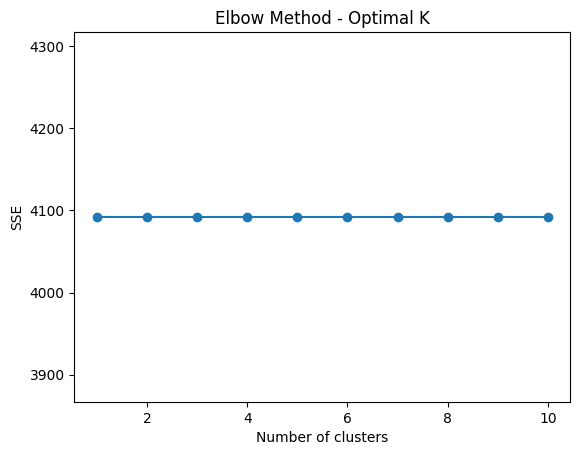

In [16]:
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)


plt.plot(range(1, 11), sse, marker='o')
plt.title("Elbow Method - Optimal K")
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()


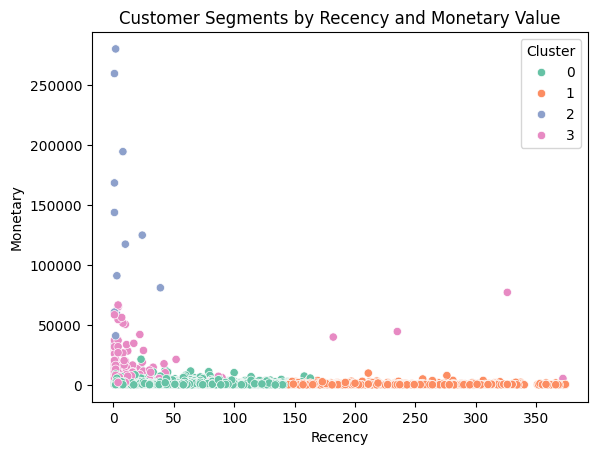

In [17]:
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)
sns.scatterplot(data=rfm, x="Recency", y="Monetary", hue="Cluster", palette="Set2")
plt.title("Customer Segments by Recency and Monetary Value")
plt.show()



In [18]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pickle

# Step 1: Load your customer dataset
df = pd.read_csv("data.csv", encoding="ISO-8859-1")

# Step 2: Drop customers with missing IDs
df.dropna(subset=["CustomerID"], inplace=True)

# Step 3: Calculate Total Price per transaction
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

# Step 4: Group by customer and create features
customer_df = df.groupby("CustomerID").agg({
    "InvoiceNo": "nunique",      # Number of purchases
    "Quantity": "sum",           # Total quantity bought
    "TotalPrice": "sum",         # Lifetime Value (target)
    "InvoiceDate": "count"       # Proxy for purchase frequency
}).reset_index()

customer_df.rename(columns={
    "InvoiceNo": "NumPurchases",
    "Quantity": "TotalQuantity",
    "TotalPrice": "LTV",         # This is the value we'll predict
    "InvoiceDate": "Frequency"
}, inplace=True)

# Step 5: Define features and target
X = customer_df[["NumPurchases", "TotalQuantity", "Frequency"]]
y = customer_df["LTV"]

# Step 6: Train the model
model = RandomForestRegressor()
model.fit(X, y)

# Step 7: Save the model to model.pkl
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

print("✅ Model trained and saved as model.pkl")


✅ Model trained and saved as model.pkl
